This notebook is based on [this one](https://colab.research.google.com/drive/1fXDv5N--J8uwomXJRcaSr2KUk95lIrbr) from the lecture, which originally used the CIFAR10 dataset. It has been modified to work with the MNIST dataset instead.

Information about the MNIST dataset was sourced from [PyTorch documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) and the [original MNIST website](https://yann.lecun.com/exdb/mnist/).

In [ ]:
# Code preliminaries. Run first!
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST

# Mathematical foundation


## Problem Statement

1. **Input Data**:  
   $ x_i \in \mathbb{R}^d $: $d$-dimensional feature vector for the $i$-th data point, where $d = 28 \times 28 \times 1 = 784$ for MNIST images (flattened into a 1D vector).  
   $ y_i \in \{0, 1, \ldots, 9\} $: Class label associated with $ x_i $, corresponding to one of the 10 digit classes in MNIST.

2. **Nonlinear Classifier**:  
   Our model is a multi-layer perceptron (MLP), which applies a series of linear transformations followed by non-linear activation functions to learn complex patterns in the data:
   $$
   f(x) = \text{MLP}(x),
   $$
   where the MLP consists of multiple fully connected layers with activation functions (e.g., ReLU) to introduce non-linearity.

3. **Prediction Rule**:  
   The class with the highest score is chosen as the predicted class:
   $$
   \hat{y} = \arg\max_{k} f_k(x),
   $$
   where $ f_k(x) $ is the output score (logit) for class $ k $.

4. **Objective**:  
   We aim to find the parameters of the MLP model that minimize the classification error on the training data. This is typically done by optimizing a loss function such as cross-entropy loss, which measures the difference between the predicted class probabilities (after applying Softmax) and the true labels.


## Multiple classes




### Direct Multiclass Classification

Direct multiclass classification is an approach where a single model is used to handle all classes simultaneously:

- Algorithms like softmax regression (a generalization of logistic regression) can be used to assign probabilities to each class.
- The model outputs a probability distribution over all classes, and the class with the highest probability is selected as the prediction.
- This approach is simpler and more efficient for certain problems, as it does not require training multiple binary classifiers.

#### Example
For a dataset with three classes (A, B, and C), a direct multiclass classifier will:
- Output probabilities for each class, such as $\mathbb P[A]$, $\mathbb P [B]$, and $\mathbb P[C]$.
- The class with the highest probability is chosen as the predicted class.


# Example data set

This dataset (MNIST) consists of 70,000 grayscale images of size 28x28, divided into 10 classes (digits 0–9).

**OLD:** CIFAR-10: This dataset consists of 60,000 32x32 color images divided into 10 classes, with 6,000 images per class. The classes include objects like airplanes, cars, birds, cats, and more.

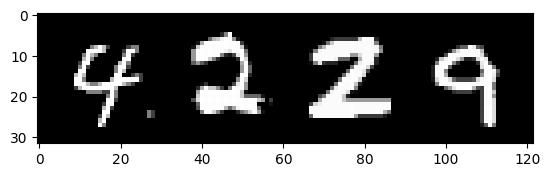

4 2 2 9


In [ ]:
# Define a sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts a PIL (Python Imaging Library) image or numpy.ndarray to a PyTorch tensor
    #transforms.Normalize((0.5,), (0.5,))  # Normalizes the tensor (mean, std)
])

# Download and load the MNIST training dataset
trainset = MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Class labels
classes = tuple(str(i) for i in range(10))

# Function to show an image
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

## Normalization (`transforms.Normalize`)
The line `transforms.Normalize((0.5,), (0.5,))` normalizes the pixel values of the MNIST dataset, which are initially in the range `[0, 1]` (after applying `ToTensor`). The normalization follows the formula:

$$
\text{Normalized Value} = \frac{\text{Pixel Value} - \text{mean}}{\text{std}}
$$

- **`mean=(0.5,)` and `std=(0.5,)`:**
  - These values are specified for a single channel (grayscale images have one channel).
  - Subtracting `0.5` shifts the range from `[0, 1]` to `[-0.5, 0.5]`.
  - Dividing by `0.5` scales the range further to `[-1, 1]`.
- This normalization step ensures that the pixel values are centered around zero and have a consistent scale, which helps machine learning models converge more effectively.

# Model setup

Compared to [this colab](https://colab.research.google.com/drive/1fXDv5N--J8uwomXJRcaSr2KUk95lIrbr) from the lecture, we create a model with multiple layers since a simple linear classifier would not effectively handle MNIST's digit classification task.

The model is a multi-layer perceptron (MLP) that outputs logits for each of the 10 digit classes. These logits are then interpreted as class scores, which can be converted into probabilities using a softmax function.

In [ ]:
# Define a multi-layer perceptron (MLP) model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Activation function (ReLU)
        self.relu = nn.ReLU()
        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # Third fully connected layer
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        # Fourth fully connected layer to output class scores
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Flatten the input tensor to (batch_size, input_size) # flattens the img
        x = x.view(x.size(0), -1)
        # Pass through the first layer and apply ReLU
        x = self.relu(self.fc1(x))
        # Pass through the second layer and apply ReLU
        x = self.relu(self.fc2(x))
        # Pass through the third layer and apply ReLU
        x = self.relu(self.fc3(x))
        # Pass through the final layer (no activation needed)
        x = self.fc4(x)
        return x

# Model parameters
input_size = 28 * 28 * 1  # MNIST images are 28x28 with 1 color channel (784)
hidden_size = 16  # Size of the hidden layers
num_classes = 10  # MNIST has 10 classes

# Instantiate the model
model = MLPClassifier(input_size, hidden_size, num_classes)

# Print the model to confirm setup
print(model)

MLPClassifier(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=10, bias=True)
)


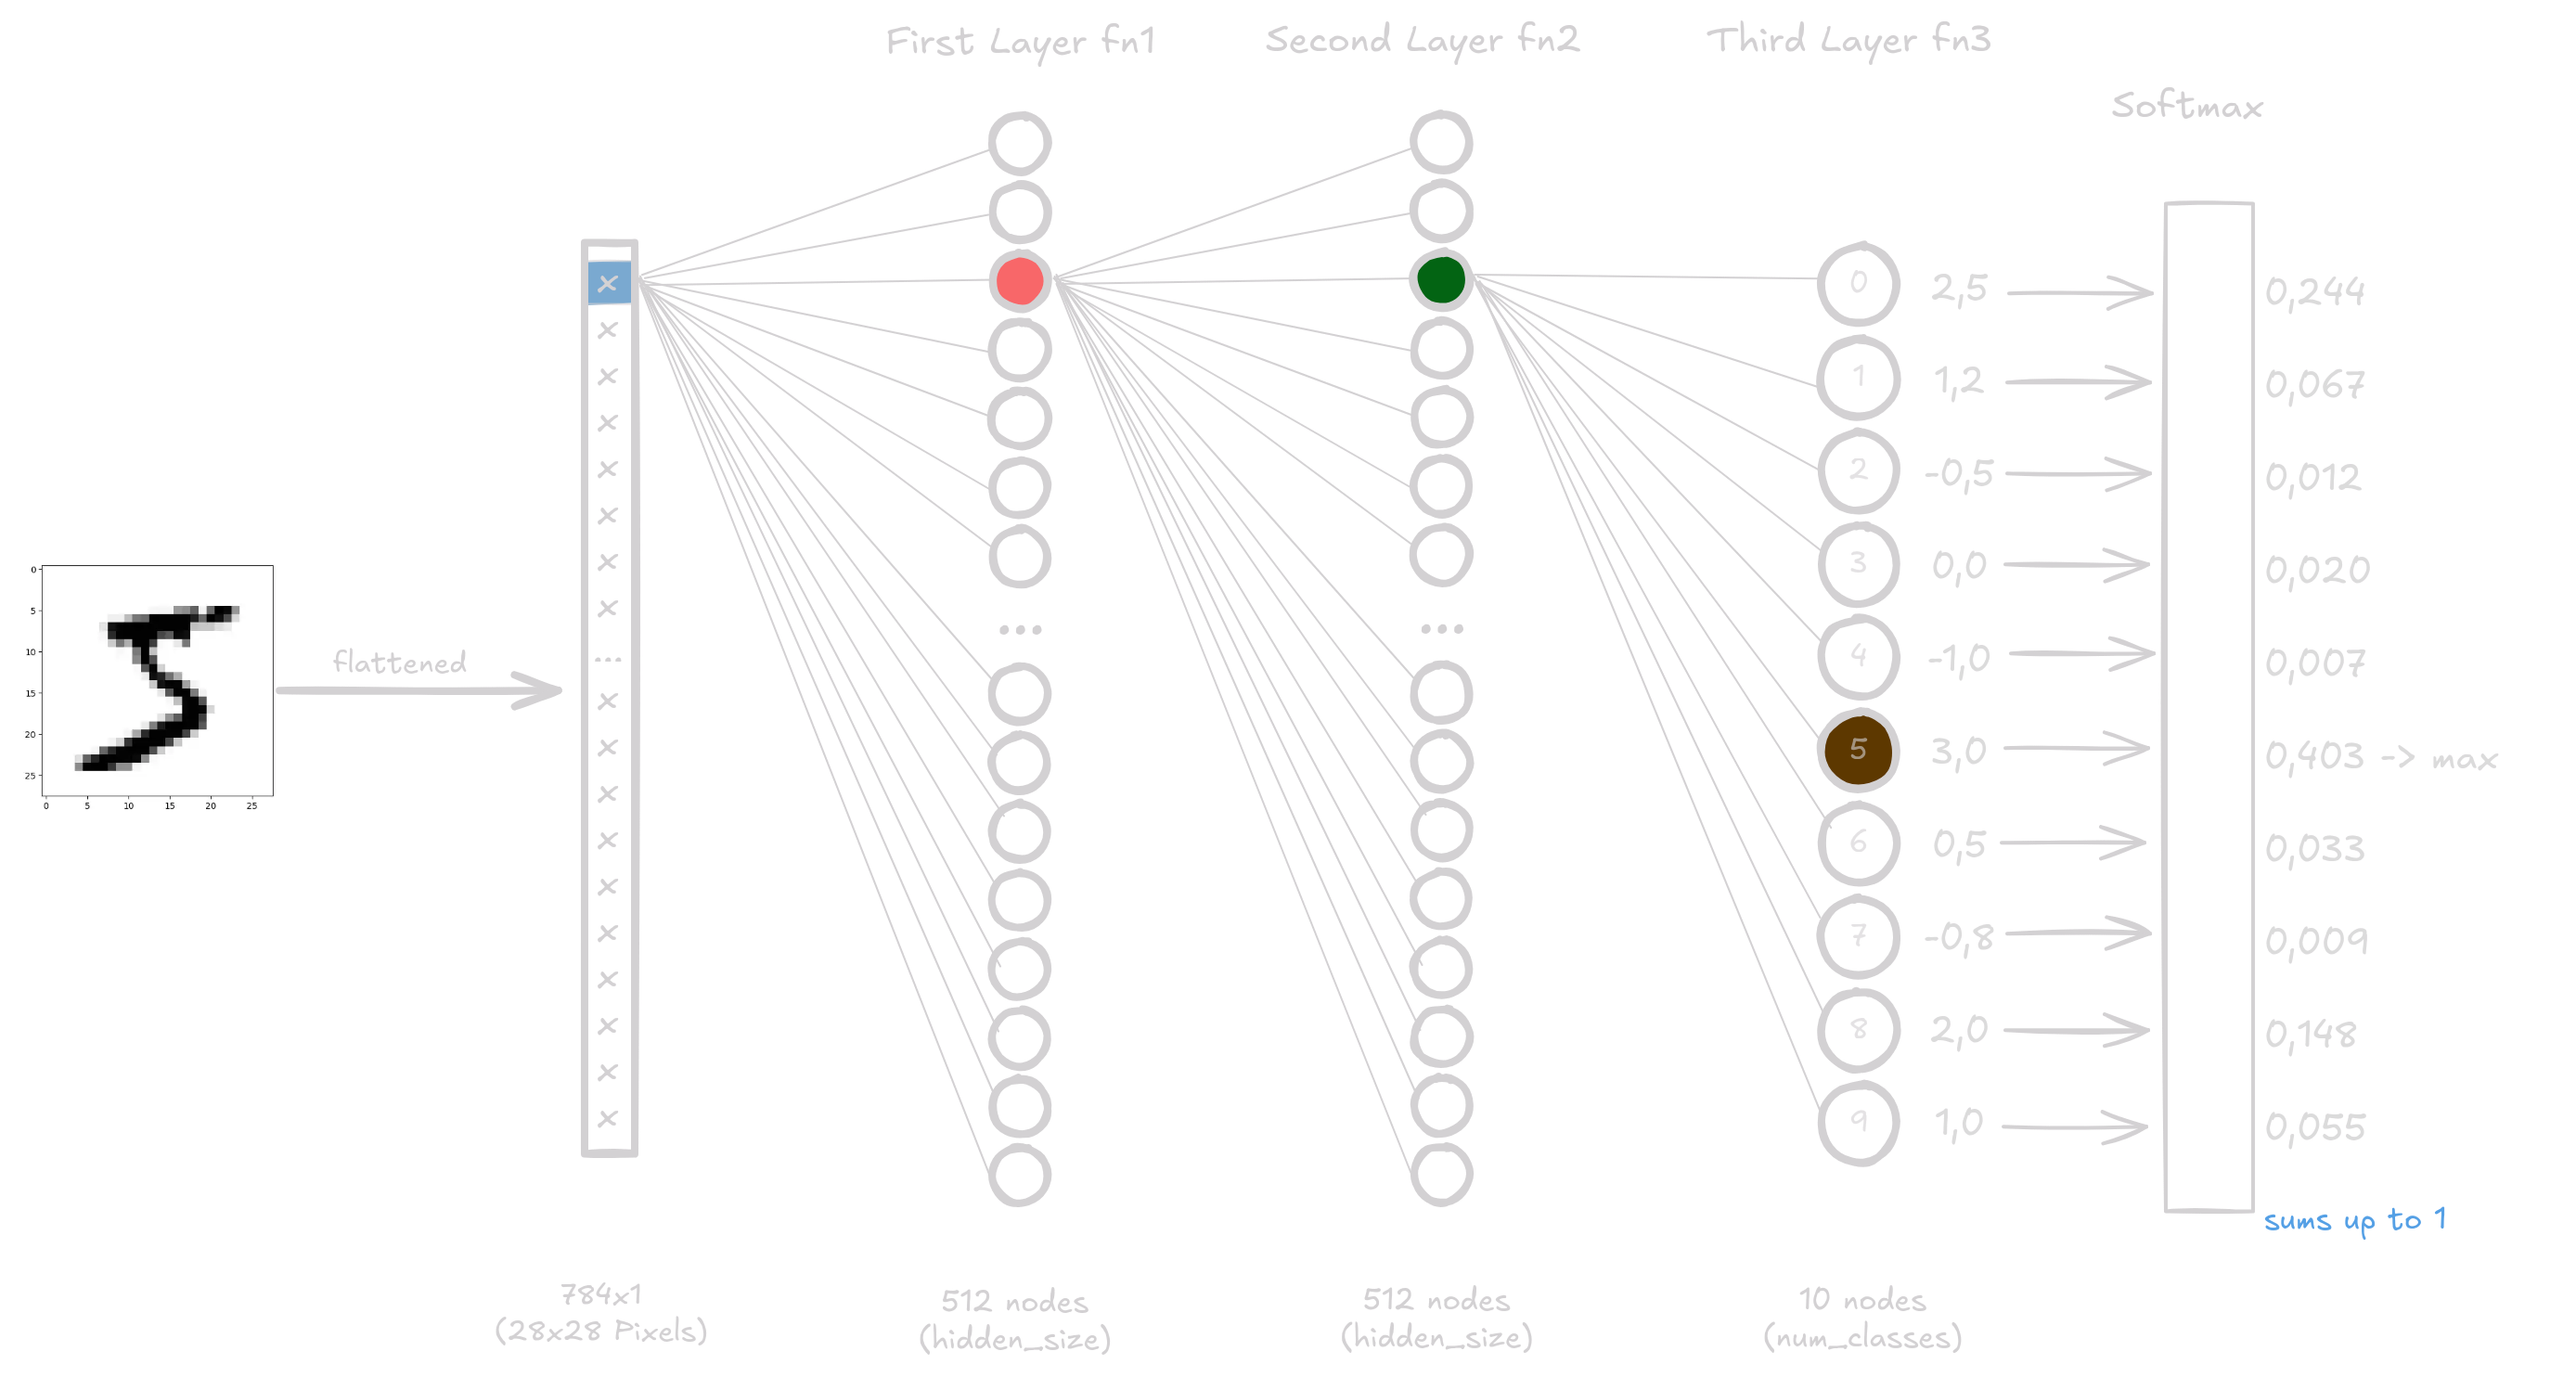

## Architecture and Functionality of Layers

### Connections from Input to the First Layer (`fc1`)
- Each of the **784 input values** (pixels from the flattened 28x28 image) is connected to **each of the 512 nodes** in the first hidden layer.
- The connections are defined by a **weight matrix** with these dimensions:
  $$
  W_{fc1} : [784, 512]
  $$

#### Weighted Sum and Bias
- Each weight in the matrix $W_{fc1}$ determines how strongly a particular pixel value ($x_i$) influences a node.
- For each node $j$, the model computes a **weighted sum of the pixel values**:
  $$
  y_j = \sum_{i=1}^{784} W_{i,j} \cdot x_i + b_j
  $$
  - $W_{i,j}$: Weight of the connection between pixel $x_i$ and node $j$.
  - $b_j$: Bias for node $j$.

---

### Second Layer (`fc2`)
- The **output from the first layer** has dimensions **$[512, 1]$**.
- The second fully connected layer processes these values using a new weight matrix with dimensions:
  $$
  W_{fc2} : [512, 512]
  $$

---

### Third Layer (`fc3`)
- The **output from the second layer** has dimensions **$[512, 1]$**.
- This layer produces the **raw logits** for the 10 classes (digits 0–9).
- The weight matrix of the final layer has dimensions:
  $$
  W_{fc3} : [512, 10]
  $$
- The logits are unnormalized values representing the model's confidence for each class. (Softmax is applied later)


**Remarks**

1. **`super(MLPClassifier, self).__init__()`**:
   - This line calls the constructor of the parent class, `nn.Module`. It ensures that the model is properly initialized and inherits all the functionalities of `nn.Module`.
   - This is a necessary step when creating custom neural network modules in PyTorch, as it sets up the model to work correctly with PyTorch's internal mechanisms.

2. **Fully Connected Layers (`nn.Linear`)**:
   - In the MLP model, we use multiple fully connected layers defined using `nn.Linear`.
   - Each `nn.Linear` layer learns weights and biases during training. It transforms the input features to the specified output size.
   - Example in the context of CIFAR-10:
     - The first layer might take `input_size = 3072` features (flattened image) and transform them to a hidden layer of size `hidden_size`.
     - The final layer outputs `num_classes = 10` scores, one for each class in CIFAR-10.

3. **ReLU Activation Function**:
   - We use the ReLU (Rectified Linear Unit) activation function between the fully connected layers.
   - **Purpose**: ReLU introduces non-linearity to the model, enabling it to learn complex patterns. It outputs the input directly if it is positive; otherwise, it outputs zero:

  $$
  \text{ReLU}(x) = \max(0, x)
  $$

   - ReLU is widely used in deep learning because it helps mitigate the vanishing gradient problem, making training more efficient.

4. **`x = x.view(x.size(0), -1)`**:
   - This line flattens the input tensor to a 2D shape of `(batch_size, input_size)`.
   - The fully connected layers expect a 2D input: `(number of samples, number of features)`. Flattening ensures the input shape is correct for these layers.



# Loss




## Multi-class: cross-entropy loss

Cross-entropy loss is a commonly used loss function for multiclass classification problems. It measures the difference between the true distribution of class labels and the predicted probability distribution.

### Definition
For a multiclass classification problem with $K$ classes, cross-entropy loss is defined as:
$$
L = -\frac{1}{n} \sum_{i=1}^n \sum_{k=1}^K y_{i,k} \log(p_{i,k})
$$
where:
- $n$ is the number of samples.
- $y_{i,k}$ is a binary indicator (0 or 1) that denotes whether the $i$-th sample belongs to class $k$.
- $p_{i,k}$ is the predicted probability of the $i$-th sample belonging to class $k$.

**Remarks**

- Cross-entropy loss increases as the predicted probability for the true class decreases.
- It encourages the model to assign high probabilities to the correct class labels.

In [ ]:
# Define cross-entropy loss function
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Forward pass of the model on the batch
outputs = model(images)  # Outputs have shape (batch_size, num_classes)

# Compute the loss
# CrossEntropyLoss expects the raw logits (outputs) and integer class labels
loss = criterion(outputs, labels)  # No need to squeeze, labels should be of shape (batch_size)
print("Cross-Entropy Loss:", loss.item())


Cross-Entropy Loss: 2.292351245880127


# Optimizer setup

In [ ]:
# Define the optimizer for updating the model parameters
# - optim.SGD: Stochastic Gradient Descent (SGD) optimizer
# - model.parameters(): The parameters of the model that will be updated during training
# - lr=0.01: The learning rate, which controls how much to adjust the model's parameters with respect to the loss gradient
# - momentum=0.9: Momentum helps accelerate gradients in the right direction and dampens oscillations, improving convergence speed
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


# Training loop

In [ ]:
# Training loop with progress bar and intermediate prints
num_epochs = 3  # Number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    # Initialize the progress bar with tqdm
    progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, labels) in progress_bar:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Outputs have shape (batch_size, num_classes)

        # Compute the loss
        # CrossEntropyLoss expects raw logits and integer class labels
        loss = criterion(outputs, labels)

        # Backward pass
        # Computes the gradient with respect to predicted logits
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {running_loss/len(trainloader):.4f}")

print("Training complete!")



Epoch 1/3: 100%|██████████| 15000/15000 [01:41<00:00, 148.45it/s, loss=0.0413]


Epoch 1/3, Average Loss: 0.4936


Epoch 2/3: 100%|██████████| 15000/15000 [01:39<00:00, 150.34it/s, loss=0.104]


Epoch 2/3, Average Loss: 0.2394


Epoch 3/3: 100%|██████████| 15000/15000 [01:39<00:00, 150.07it/s, loss=0.000988]


Epoch 3/3, Average Loss: 0.2047
Training complete!


# Model evaluation




### Evaluation Process with Softmax Outputs

1. **Softmax Layer Output**:
   - Suppose the model outputs logits $z_i$ for each class $i$ (where $i = 1, 2, \ldots, K$ and $K$ is the number of classes).
   - The *softmax* function converts these logits into probabilities as follows:
     $$
     p_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
     $$
   - Here, $p_i$ represents the probability that the input belongs to class $i$. The probabilities for all classes $p_1, p_2, \ldots, p_K$ sum to 1.

2. **Predicted Class**:
   - To make a prediction, we select the class with the highest probability:
     $$
     \hat{y} = \arg\max_{i} p_i
     $$
   - Here, $\hat{y}$ is the predicted class index, and $\arg\max$ returns the index $i$ where $p_i$ is maximum.

3. **Accuracy Calculation**:
   - Once we have the predicted class $\hat{y}$ for each input and the true class $y$, we calculate the accuracy score.
   - The accuracy is given by:
     $$
     \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
     $$
   - Mathematically, if we have $N$ total samples, the accuracy can be expressed as:

     $$
     \text{Accuracy} = \frac{1}{N} \sum_{n=1}^N \mathbb I(\hat{y}_n = y_n)
     $$
   - Here, $\mathbb I(\hat{y}_n = y_n)$ is an indicator function that equals 1 if the predicted class $\hat{y}_n$ is the same as the true class $y_n$, and 0 otherwise.

### Steps in Evaluation:
1. **Compute Softmax Probabilities**:
   - From the raw logits $z$ produced by the model, apply the softmax function to get class probabilities.
2. **Determine the Predicted Class**:
   - Use $\arg\max$ to find the class with the highest probability.
3. **Compare Predictions with True Labels**:
   - Calculate the accuracy by comparing the predicted class $\hat{y}$ with the true class $y$ for all samples.



In [ ]:
# Function to evaluate the model's performance
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []  # List to store all predicted labels
    all_labels = []  # List to store all true labels

    # Initialize the progress bar with tqdm
    progress_bar = tqdm(dataloader, desc="Evaluating", total=len(dataloader))

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in progress_bar:
            # Forward pass to get model predictions
            outputs = model(images)  # Outputs have shape (batch_size, num_classes)
            preds = torch.argmax(outputs, dim=1)  # Get the class index with the highest score

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate and print the overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy:.4f}")

# Example: Evaluate the model on the entire dataset
evaluate_model(model, trainloader)


Evaluating: 100%|██████████| 15000/15000 [00:16<00:00, 921.30it/s]

Overall Accuracy: 0.9451


## Visual evaluation

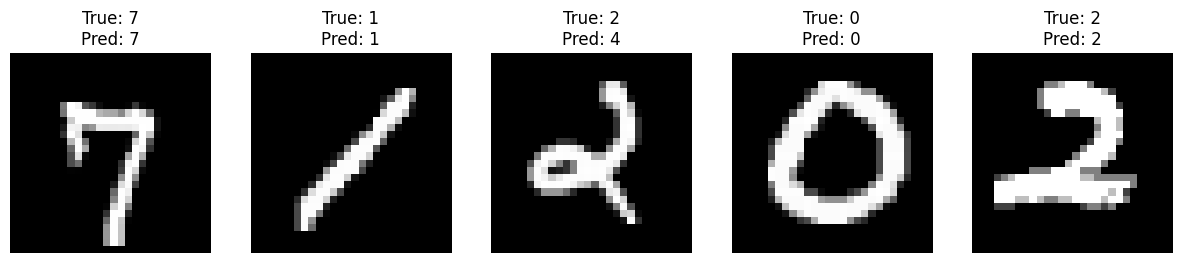

In [ ]:
# Function to display images along with their true and predicted labels
def visualize_model_predictions(model, dataloader, class_names, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images_shown = 0

    # Set up a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in dataloader:
            # Forward pass to get model predictions
            outputs = model(images)  # Outputs have shape (batch_size, num_classes)
            preds = torch.argmax(outputs, dim=1)  # Get the class index with the highest score

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                # Get the true and predicted labels
                true_label = class_names[labels[i].item()]
                predicted_label = class_names[preds[i].item()]

                # Display the image
                image = images[i].permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize the image
                axes[images_shown].imshow(image, cmap='gray')
                axes[images_shown].axis('off')
                axes[images_shown].set_title(f"True: {true_label}\nPred: {predicted_label}")

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.show()

# Example: Visualize model predictions for MNIST
class_names = tuple(str(i) for i in range(10))
visualize_model_predictions(model, trainloader, class_names)